In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import uproot
import root_pandas as rpd
from root_pandas import read_root
from matplotlib import rc
import R2h_module as r2h

mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
rc('font', weight='bold')
colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

Welcome to JupyROOT 6.22/09


# Get data from Ntuples to dataframes

In [2]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df


# Getting Data

In [3]:
%%time
df = {}
df_trigger = {}
#path_data="/home/seba/CreatePairTuples"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.99 s, sys: 385 ms, total: 5.37 s
Wall time: 5.37 s


# Apply selection to datasets


In [4]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key] = r2h.applyCuts(df[key],isMC=isMC)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    print (key)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
    print (' ')    


key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
h1_p<5.0  131585  (100.00  %)
inelasticity < 0.85 131585  (100.00  %)
h1_pid = pions (trigger) 131585  (100.00  %)
Nu>2.2 and Nu<4.2 129258  (98.23  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 129258  (100.00  %)
2.2 < nu < 4.2 129258  (100.00  %)
h1_p<5 GeV  129258  (100.00  %)
h2_p<5 GeV 129258  (100.00  %)
secondary hadrons are pions 129258  (100.00  %)
leading hadrons are pions 129258  (100.00  %)
0.2<h2_p<5.0 129258  (100.00  %)
0.2<h1_p<5.0 129258  (100.00  %)
10<h2_th<120 129258  (100.00  %)
Theta/P fiducial region selected 129258  (100.00  %)
10< h1_th<120 129258  (100.00  %)
Theta/P fiducial region selected for trigger 129258  (100.00  %)

key:  D_C
Entries before cut  185530
Q2>1.0 and Q2<4.0 185530  (100.00  %)
h1_p<5.0  185525  (100.00  %)
inelasticity < 0.85 185525  (100.00  %)
h1_pid = pions (trigger) 185525  (100.00  %)
Nu>2.2 and Nu<4.2 182357  (98.29  %)
Starting election on di

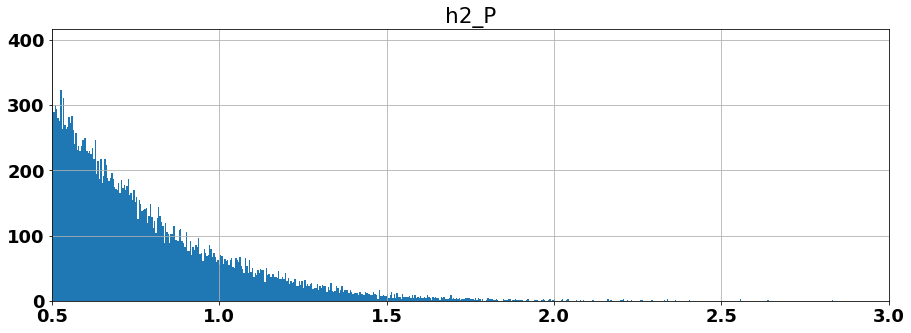

In [5]:
# Testing some distributions
#print (df['Pb'].keys())
#df_mc['Fe'].eval('Xb=Q2/(2*0.938272*nu)', inplace=True)
#df['Pb'].hist(figsize=(12,12),bins=100,column=['h1_StatCC','h2_StatCC', 'h1_Nphe', 'h2_Chi2CC'])
#plt.show()

df['Pb'].eval('h1_P=sqrt(h1_z*nu*h2_z*nu-0.13957*0.13957)', inplace=True)
df['Pb'].eval('h2_P=sqrt(h2_z*nu*h2_z*nu-0.13957*0.13957)', inplace=True)
df['Pb'].query('Q2>1').hist(
    figsize=(15,5),bins=1000,column=['h2_P'])
plt.xlim(0.5,3)
plt.show()



# Nominal case result plot
**The idea here is to make sure the code is working fine, I should reproduce what I had before**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

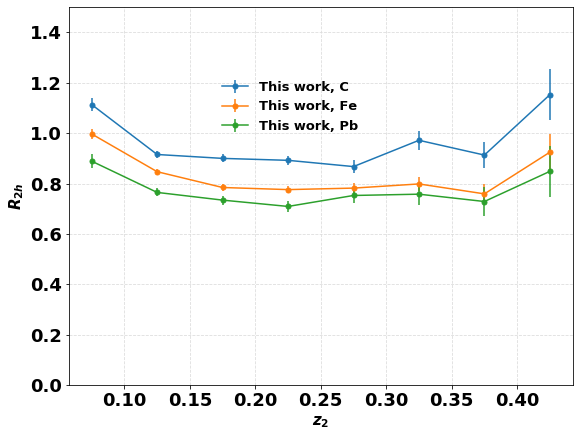

In [6]:
fig = plt.figure(figsize=(8,6))

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    print('for target ',target, ' : ',(err_nom/r_nom)*100)
    plt.errorbar(x_nom,r_nom,yerr = err_nom  ,  fmt='-o',ms=5, label='This work, %s'%target)  
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=1.0, top=1.0)    
fig.legend(loc='upper center',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
plt.ylim([0.,1.5])
plt.ylabel('$R_{2h}$',fontsize=15,fontweight="bold")
plt.xlabel('$z_{2}$',fontsize=15,fontweight="bold")

#print('for target ',target, ' : ',(err_nom/r_nom)*100)

plt.show()

# $\color{red}{\textbf{Getting the ratio of nominal case and variations}}$

**$\Delta Z$ Variations**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

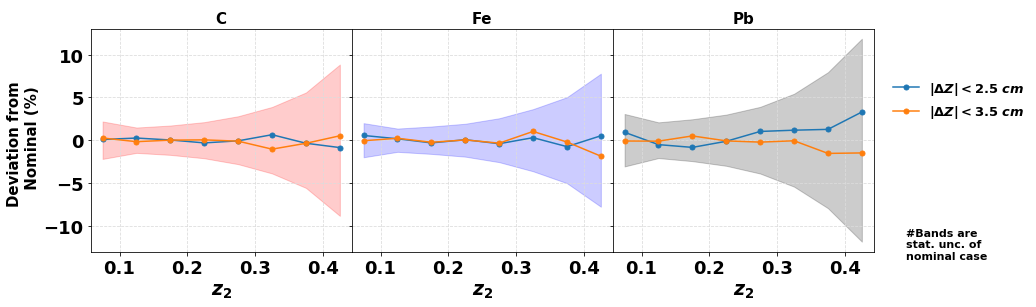

In [7]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta Z|<2.5$ $cm$','$|\Delta Z|<3.5$ $cm$']

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_DeltaZ.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

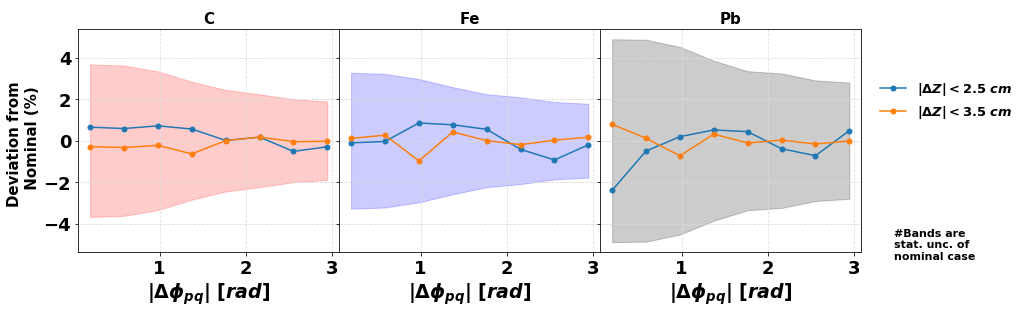

In [8]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta Z|<2.5$ $cm$','$|\Delta Z|<3.5$ $cm$']

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_DeltaZ_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

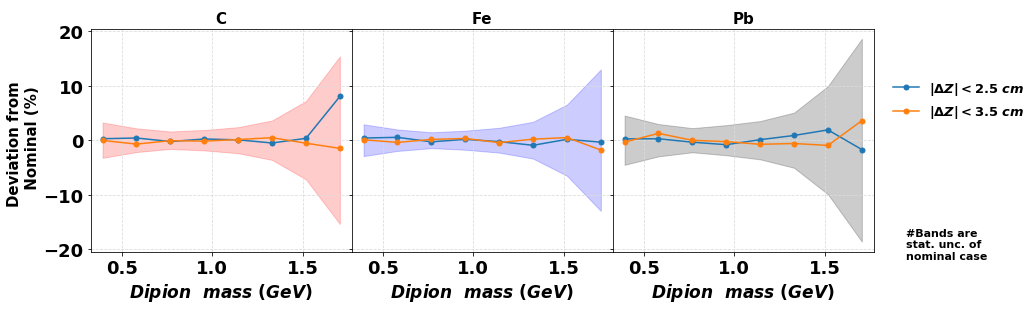

In [9]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta Z|<2.5$ $cm$','$|\Delta Z|<3.5$ $cm$']

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=17,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_DeltaZ_dpionMass.pdf', bbox_inches='tight')

plt.show()

**Vertex selection variation**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  and h1_z>0.5 and abs(h2_deltaZ)<3

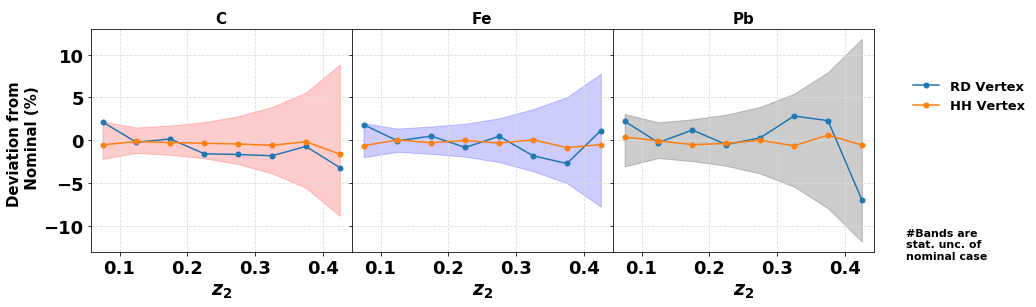

In [10]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_VertexCuts.pdf', bbox_inches='tight')

plt.show()




**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  and h1_z>0.5 and abs(h2_deltaZ)<3

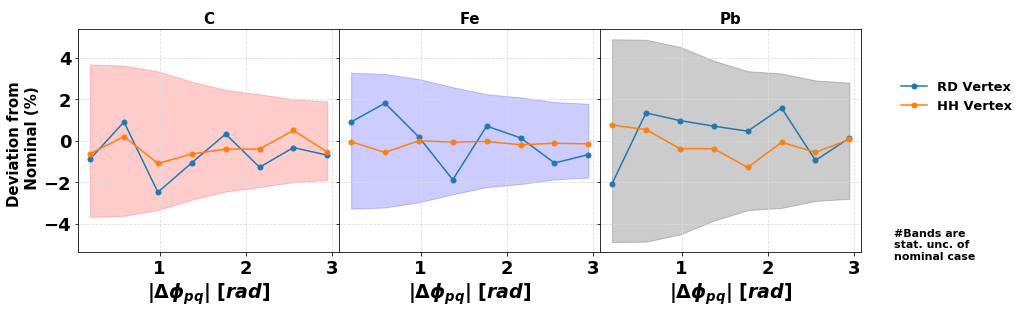

In [11]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_VertexCuts_dphi.pdf', bbox_inches='tight')

plt.show()



**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

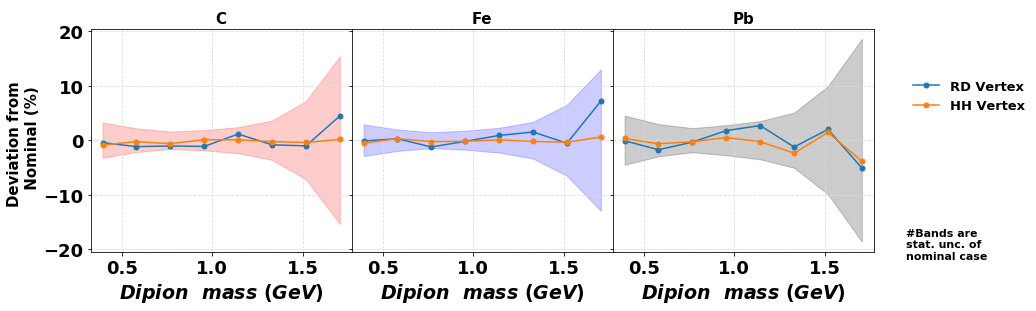

In [12]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_VertexCuts_dpionMass.pdf', bbox_inches='tight')

plt.show()


# Sector variations

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==5
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

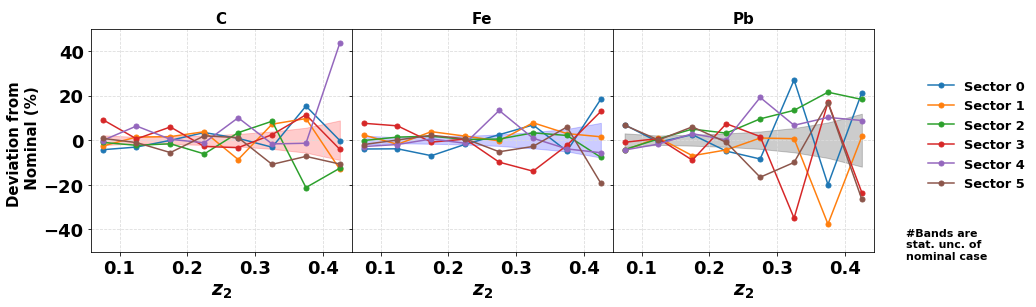

In [51]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
axs[0].set_ylim(-50,50)
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_Sectors_z2.pdf', bbox_inches='tight')
plt.savefig('diH_Sectors_z2.png', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==5
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

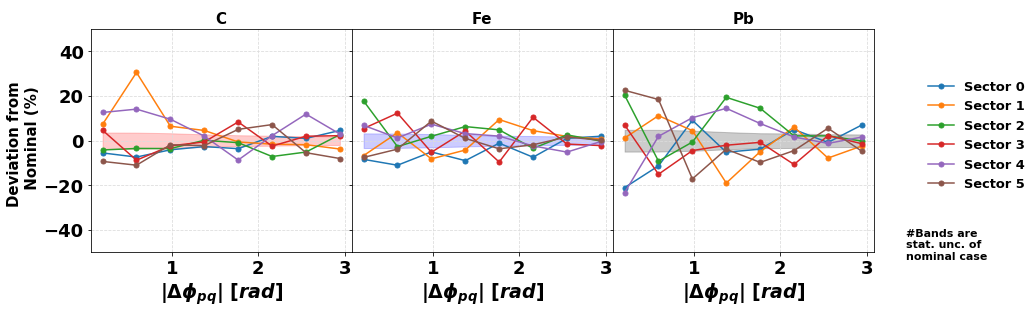

In [50]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
axs[0].set_ylim(-50,50)
plt.savefig('diH_Sectors_dphi.pdf', bbox_inches='tight')
plt.savefig('diH_Sectors_dphi.png', bbox_inches='tight')
plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==5
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pi

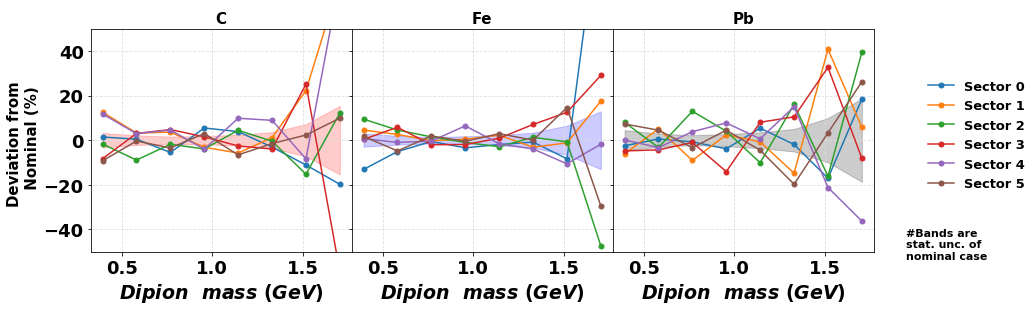

In [48]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
axs[0].set_ylim(-50,50)
plt.savefig('diH_Sectors_dpionMass.pdf', bbox_inches='tight')
plt.savefig('diH_Sectors_dpionMass.png', bbox_inches='tight')
plt.show()

# Sampling Fraction variation

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

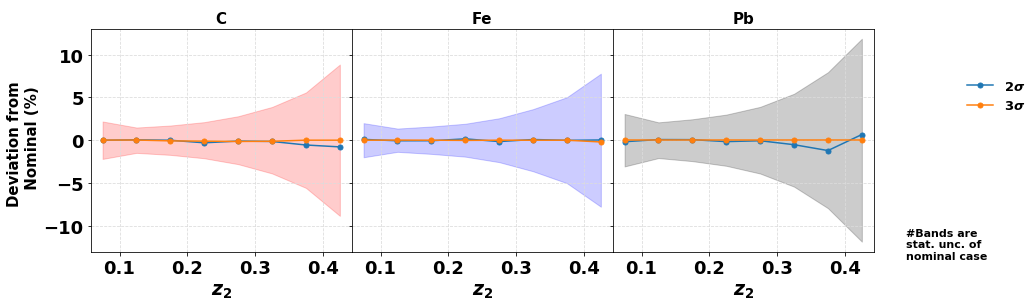

In [16]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)
plt.savefig('diH_SamplingFraction.pdf', bbox_inches='tight')

plt.show()



**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

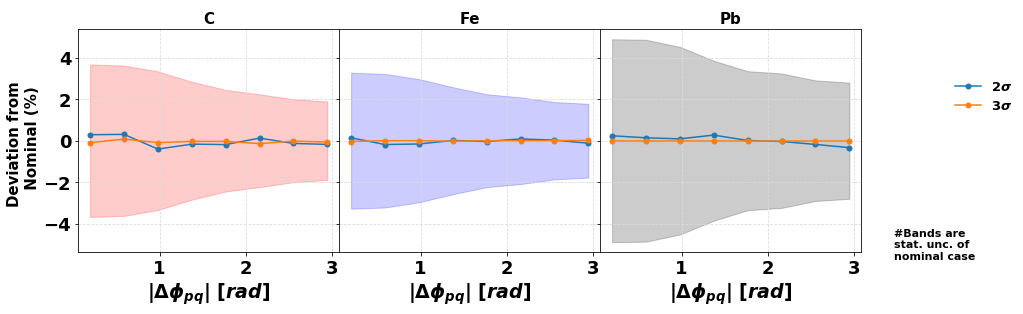

In [17]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)
plt.savefig('diH_SamplingFraction_dphi.pdf', bbox_inches='tight')

plt.show()



**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

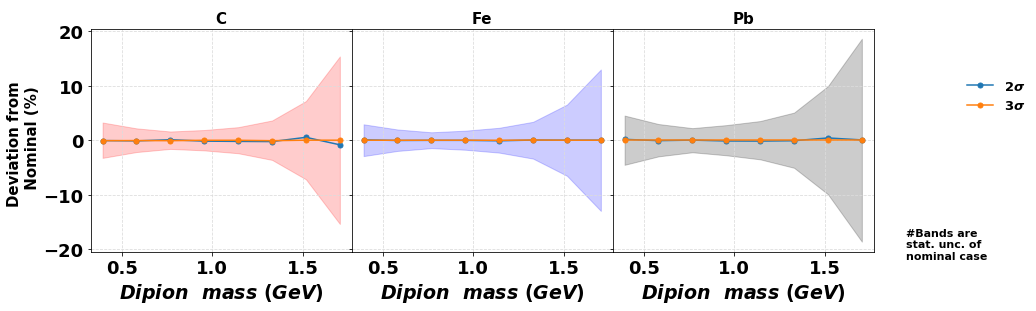

In [18]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)
plt.savefig('diH_SamplingFraction_dpionMass.pdf', bbox_inches='tight')

plt.show()



# $z_{1}$ threshold value, for the trigger

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

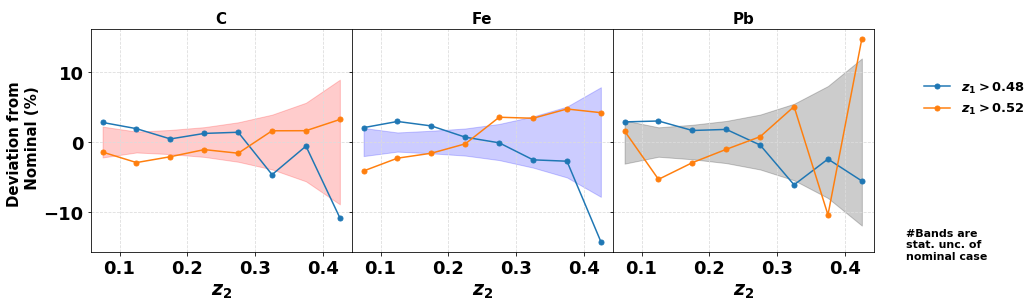

In [19]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.48 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 )) 

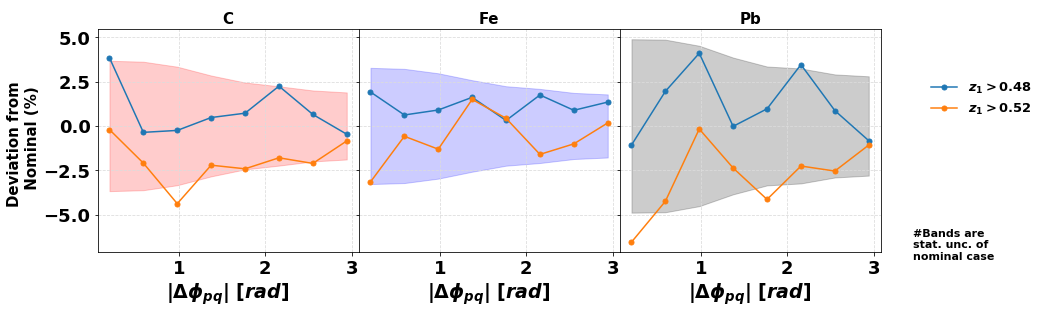

In [20]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.48 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 )) 

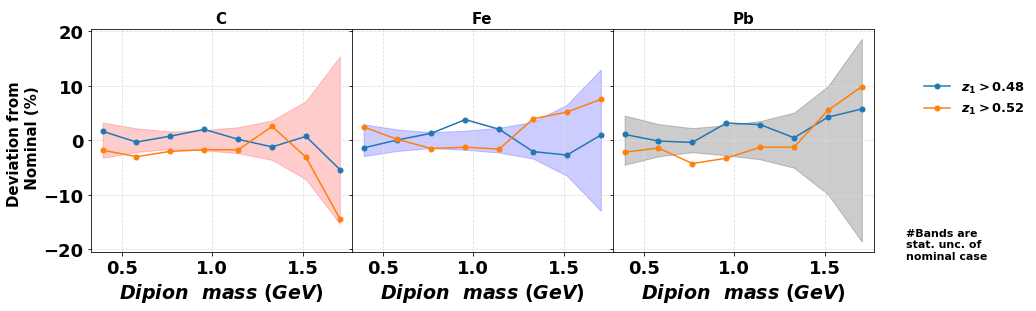

In [21]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.48 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

# Nphe for $\pi^{+}$ selection

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

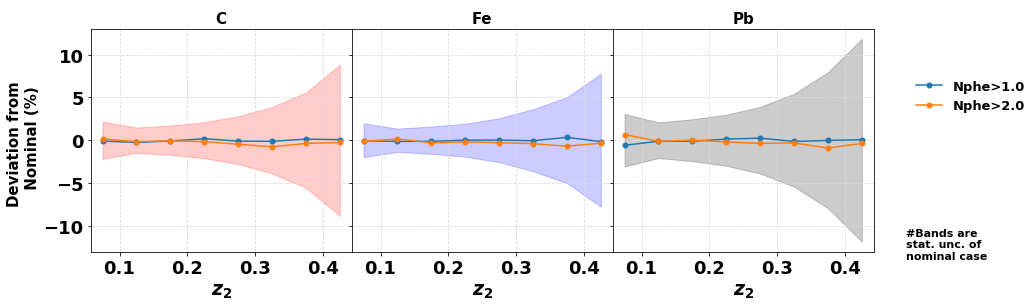

In [22]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
p_thr=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])
plt.savefig('diH_Nphethreshold_piPlus.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

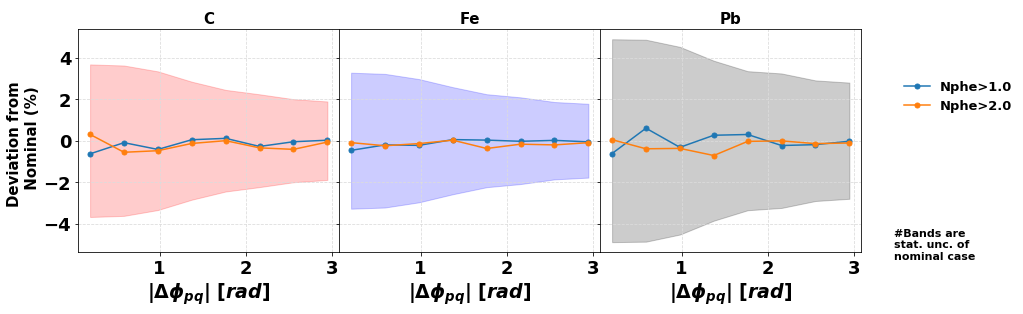

In [23]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
p_thr=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi',  
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])
plt.savefig('diH_Nphethreshold_piPlus_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

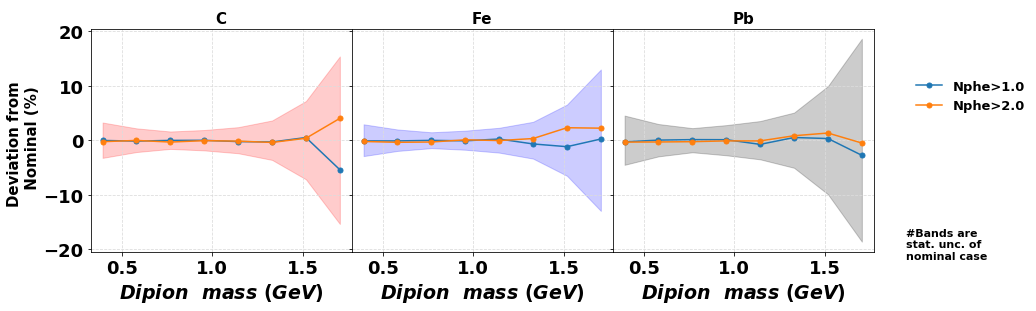

In [24]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
p_thr=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])
plt.savefig('diH_Nphethreshold_piPlus_dpionMass.pdf', bbox_inches='tight')

plt.show()

# P theshold  for $\pi^{+}$ selection

In [25]:
%%time
path_data="/home/seba/di-hadron/P25"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['P25%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['P25D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['P25%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['P25D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.91 s, sys: 180 ms, total: 5.09 s
Wall time: 5.08 s


In [26]:
%%time
path_data="/home/seba/di-hadron/P30"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['P30%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['P30D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['P30%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['P30D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 5.24 s, sys: 280 ms, total: 5.52 s
Wall time: 5.51 s


In [27]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key] = r2h.applyCuts(df[key],isMC=isMC)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    print (key)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
    print (' ')   


key:  C
Entries before cut  129258
Q2>1.0 and Q2<4.0 129258  (100.00  %)
h1_p<5.0  129258  (100.00  %)
inelasticity < 0.85 129258  (100.00  %)
h1_pid = pions (trigger) 129258  (100.00  %)
Nu>2.2 and Nu<4.2 129258  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 129258  (100.00  %)
2.2 < nu < 4.2 129258  (100.00  %)
h1_p<5 GeV  129258  (100.00  %)
h2_p<5 GeV 129258  (100.00  %)
secondary hadrons are pions 129258  (100.00  %)
leading hadrons are pions 129258  (100.00  %)
0.2<h2_p<5.0 129258  (100.00  %)
0.2<h1_p<5.0 129258  (100.00  %)
10<h2_th<120 129258  (100.00  %)
Theta/P fiducial region selected 129258  (100.00  %)
10< h1_th<120 129258  (100.00  %)
Theta/P fiducial region selected for trigger 129258  (100.00  %)

key:  D_C
Entries before cut  182356
Q2>1.0 and Q2<4.0 182356  (100.00  %)
h1_p<5.0  182356  (100.00  %)
inelasticity < 0.85 182356  (100.00  %)
h1_pid = pions (trigger) 182356  (100.00  %)
Nu>2.2 and Nu<4.2 182356  (100.00  %)
Starting election on 

Q2>1.0 and Q2<4.0 272879  (100.00  %)
h1_p<5.0  272874  (100.00  %)
inelasticity < 0.85 272874  (100.00  %)
h1_pid = pions (trigger) 272874  (100.00  %)
Nu>2.2 and Nu<4.2 268718  (98.48  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 268718  (100.00  %)
2.2 < nu < 4.2 268718  (100.00  %)
h1_p<5 GeV  268718  (100.00  %)
h2_p<5 GeV 268717  (100.00  %)
secondary hadrons are pions 268717  (100.00  %)
leading hadrons are pions 268717  (100.00  %)
0.2<h2_p<5.0 268717  (100.00  %)
0.2<h1_p<5.0 268717  (100.00  %)
10<h2_th<120 268717  (100.00  %)
Theta/P fiducial region selected 268717  (100.00  %)
10< h1_th<120 268717  (100.00  %)
Theta/P fiducial region selected for trigger 268717  (100.00  %)

key:  P30C
Entries before cut  133939
Q2>1.0 and Q2<4.0 133939  (100.00  %)
h1_p<5.0  133933  (100.00  %)
inelasticity < 0.85 133933  (100.00  %)
h1_pid = pions (trigger) 133933  (100.00  %)
Nu>2.2 and Nu<4.2 131480  (98.17  %)
Starting election on dipion variables
This is Data
Q2>1.0 

Q2>1.0 and Q2<4.0 922773  (100.00  %)
h1_p<5.0  922762  (100.00  %)
inelasticity < 0.85 922762  (100.00  %)
h1_pid = pions (trigger) 922762  (100.00  %)
Nu>2.2 and Nu<4.2 909260  (98.54  %)
 
P30Fe_trigger
Entries before cut  799926
Q2>1.0 and Q2<4.0 799925  (100.00  %)
h1_p<5.0  799908  (100.00  %)
inelasticity < 0.85 799908  (100.00  %)
h1_pid = pions (trigger) 799908  (100.00  %)
Nu>2.2 and Nu<4.2 787798  (98.49  %)
 
P30D_Fe_trigger
Entries before cut  1367739
Q2>1.0 and Q2<4.0 1367739  (100.00  %)
h1_p<5.0  1367717  (100.00  %)
inelasticity < 0.85 1367717  (100.00  %)
h1_pid = pions (trigger) 1367717  (100.00  %)
Nu>2.2 and Nu<4.2 1349972  (98.70  %)
 
P30Pb_trigger
Entries before cut  296838
Q2>1.0 and Q2<4.0 296838  (100.00  %)
h1_p<5.0  296828  (100.00  %)
inelasticity < 0.85 296828  (100.00  %)
h1_pid = pions (trigger) 296828  (100.00  %)
Nu>2.2 and Nu<4.2 291810  (98.31  %)
 
P30D_Pb_trigger
Entries before cut  1425843
Q2>1.0 and Q2<4.0 1425843  (100.00  %)
h1_p<5.0  1425821 

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

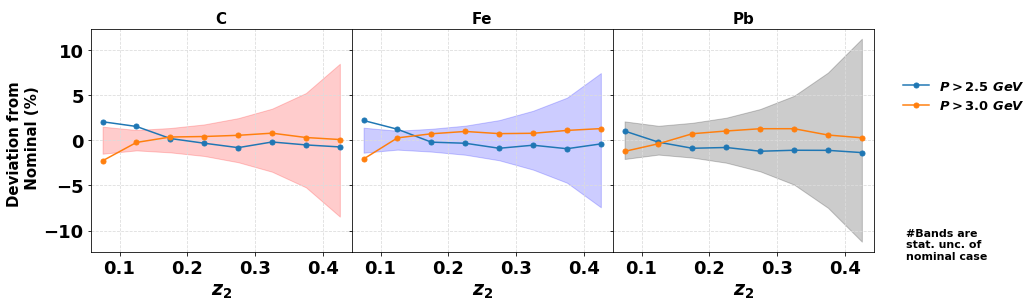

In [28]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$P>2.5$ $GeV$','$P>3.0$ $GeV$']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=700
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_Pthreshold_piPlus.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

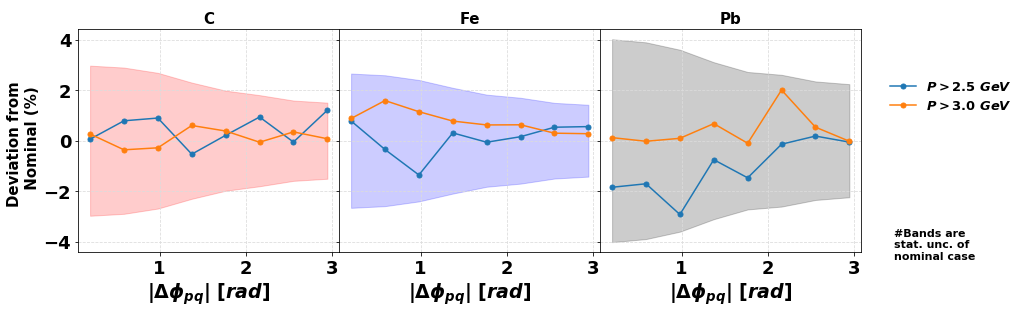

In [29]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$P>2.5$ $GeV$','$P>3.0$ $GeV$']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=700
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi',
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_Pthreshold_piPlus_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

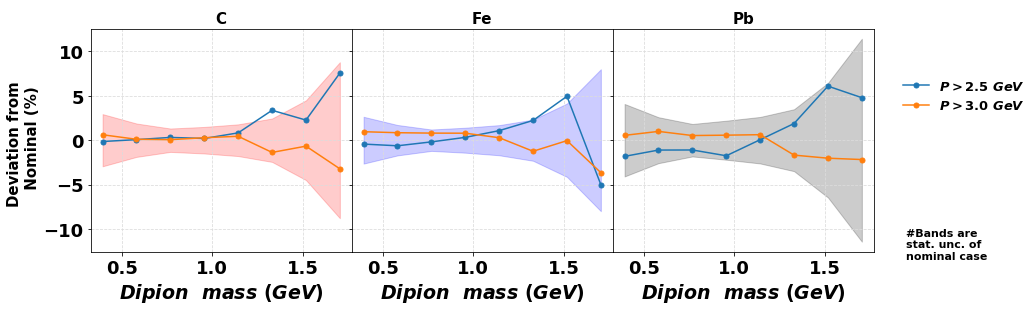

In [30]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$P>2.5$ $GeV$','$P>3.0$ $GeV$']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=700
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_Pthreshold_piPlus_dpionMass.pdf', bbox_inches='tight')

plt.show()

# CC Matching Mirror v/s Nphe for $\pi^{-}$ rejection from electron sample

In [31]:
%%time
path_data="/home/seba/di-hadron/CC_Matching"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['CC%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['CCD_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['CC%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['CCD_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)


Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 22.6 s, sys: 908 ms, total: 23.5 s
Wall time: 23.5 s


In [32]:
print(df_trigger.keys())

dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'P25C_trigger', 'P25D_C_trigger', 'P25Fe_trigger', 'P25D_Fe_trigger', 'P25Pb_trigger', 'P25D_Pb_trigger', 'P30C_trigger', 'P30D_C_trigger', 'P30Fe_trigger', 'P30D_Fe_trigger', 'P30Pb_trigger', 'P30D_Pb_trigger', 'CCC_trigger', 'CCD_C_trigger', 'CCFe_trigger', 'CCD_Fe_trigger', 'CCPb_trigger', 'CCD_Pb_trigger'])


In [33]:
%%time
for key in df.keys():
    isMC = False
    if 'CC' in key:
        print ('\nkey: ',key)
        df[key] = r2h.applyCuts(df[key],isMC=isMC)
        df[key] = r2h.applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    if 'CC' in key:
        print (key)
        df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
        print (' ')   


key:  CCC
Entries before cut  1393282
Q2>1.0 and Q2<4.0 1393282  (100.00  %)
h1_p<5.0  1393255  (100.00  %)
inelasticity < 0.85 1393255  (100.00  %)
h1_pid = pions (trigger) 272615  (19.57  %)
Nu>2.2 and Nu<4.2 267924  (98.28  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 267924  (100.00  %)
2.2 < nu < 4.2 267924  (100.00  %)
h1_p<5 GeV  267924  (100.00  %)
h2_p<5 GeV 267924  (100.00  %)
secondary hadrons are pions 135841  (50.70  %)
leading hadrons are pions 135841  (100.00  %)
0.2<h2_p<5.0 135841  (100.00  %)
0.2<h1_p<5.0 135841  (100.00  %)
10<h2_th<120 135841  (100.00  %)
Theta/P fiducial region selected 135841  (100.00  %)
10< h1_th<120 135841  (100.00  %)
Theta/P fiducial region selected for trigger 135841  (100.00  %)

key:  CCD_C
Entries before cut  1235940
Q2>1.0 and Q2<4.0 1235940  (100.00  %)
h1_p<5.0  1235923  (100.00  %)
inelasticity < 0.85 1235923  (100.00  %)
h1_pid = pions (trigger) 336713  (27.24  %)
Nu>2.2 and Nu<4.2 331259  (98.38  %)
Starting elect

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

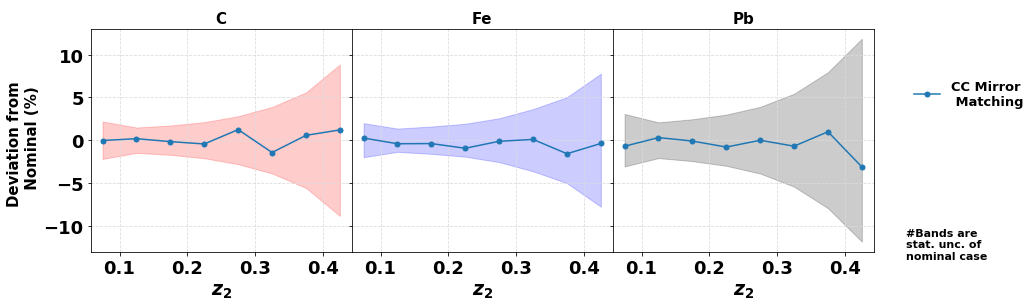

In [34]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_CCMatching.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

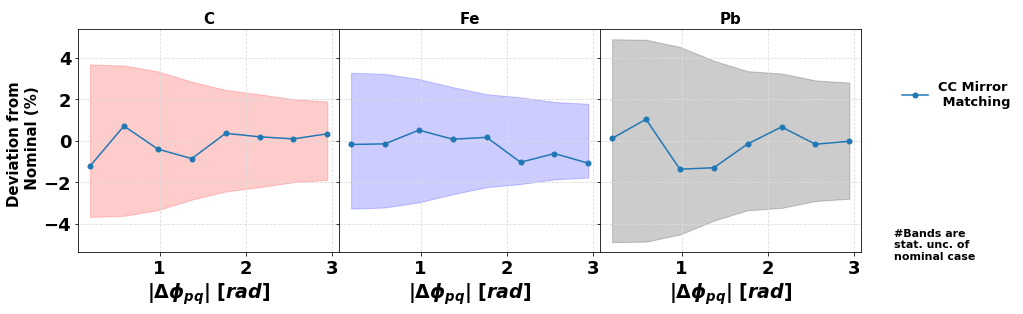

In [35]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi',
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_CCMatching_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

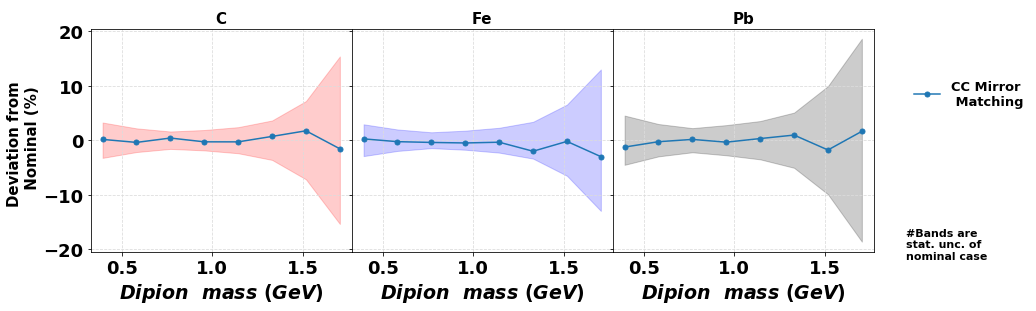

In [36]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_CCMatching_dpionMass.pdf', bbox_inches='tight')

plt.show()

**Checking the sensitivity to pairs with z1+z2>0.8, exclusive rho events are dominant for z1+z2>0.8.** 

**Here we try a comparison of z1+z2<0.8 and the nominal case**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

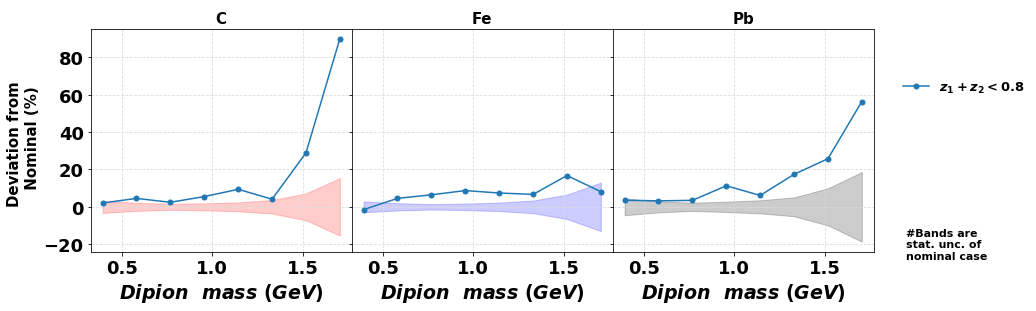

In [37]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}+z_{2}<0.8$']

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<0.8 and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])

#plt.savefig('diH_CCMatching_dpionMass.pdf', bbox_inches='tight')

plt.show()

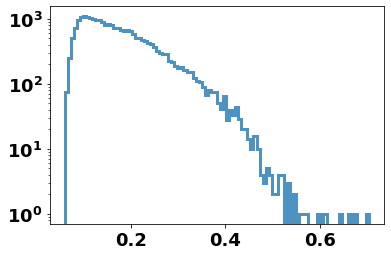

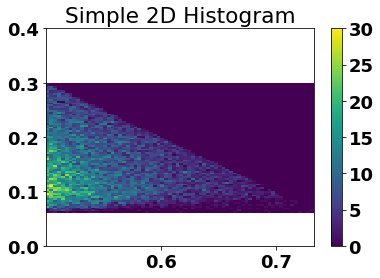

In [38]:
df['C'].eval('z_total=h1_z+h2_z', inplace=True)
cut=' and h1_z+h2_z<0.8'
plt.hist(df['C'].query(trigger_cut_nom+pair_cut_nom)['h2_z'],alpha=0.8,lw=3,bins=100, histtype='step', label='D', density=False)
plt.yscale('log')
plt.show()
#print(df['C'].columns)

plt.hist2d(df['C'].query(trigger_cut_nom+pair_cut_nom+cut).h1_z, 
           df['C'].query(trigger_cut_nom+pair_cut_nom+cut).h2_z, bins=[70,70]) 
plt.title("Simple 2D Histogram")  
plt.colorbar()
plt.ylim([0.,0.4])
plt.show()

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

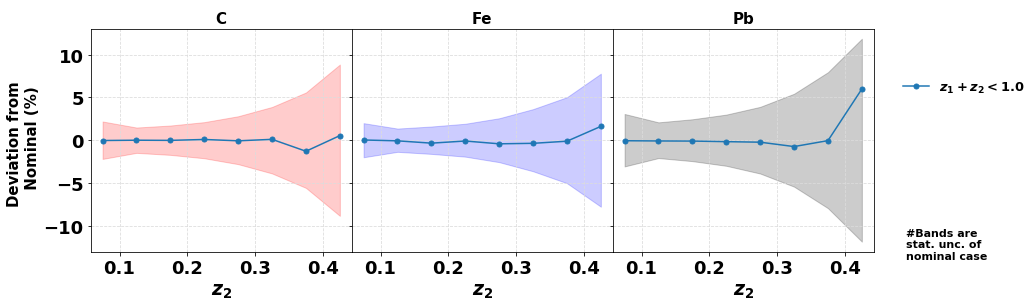

In [39]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}+z_{2}<1.0$']

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('R2h_comp_1.png', bbox_inches='tight')

plt.show()

**Using 'evnt' variable, this is like a time changing variation**

**Basic idea: we divide our sample in 3 chunks, based on evnt variable and compared the consistency between the three**

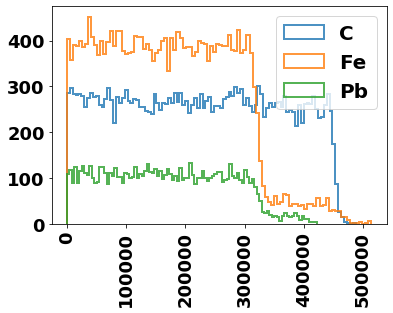

C :  1.0 -> 162433.0
C :  162434.0 -> 324866.0
C :  324867.0 -> 487299.0
Fe :  6.0 -> 171270.66666666666
Fe :  171276.66666666666 -> 342541.3333333333
Fe :  342547.3333333333 -> 513812.0
Pb :  8.0 -> 140486.33333333334
Pb :  140494.33333333334 -> 280972.6666666667
Pb :  280980.6666666667 -> 421459.0
Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*n

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>6 and evnt < 171270
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>280980 and evnt < 421459
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957

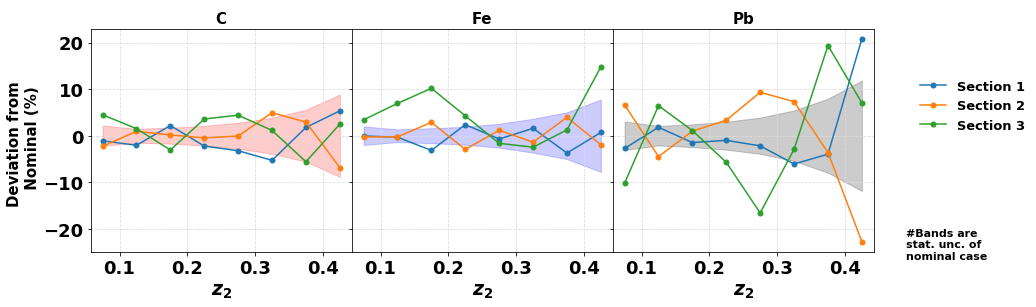

In [40]:
maxValue={}
minValue={}
numberIntervals=3
for i,target in enumerate(['C','Fe','Pb']):
    y, x, _ = plt.hist(df[target].query(trigger_cut_nom+pair_cut_nom)['evnt'],alpha=0.8,lw=2,
                       bins=100,histtype='step',  label=target, density=False)
    maxValue[target]=x.max()/numberIntervals
    minValue[target]=x.min()
#plt.xlim(400000,550000)  
#plt.xscale('log')
plt.xticks(rotation='vertical')
plt.legend()    
plt.show()

for j,target in enumerate(['C','Fe','Pb']):
    for i,tmp in enumerate(['C','Fe','Pb']):
        print (target,': ', minValue[target]+i*maxValue[target] ,'->', maxValue[target]+i*maxValue[target])
#print(maxValue)




fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Section 1', 'Section 2','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    j=0
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]    ) )
    j=1
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]    ) )
    j=2
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]    ) )

    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
                
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('R2h_comp_1.png', bbox_inches='tight')

plt.show()

In [41]:
maxValue={}
minValue={}
numberIntervals=3
#for i,target in enumerate(['C','Fe','Pb']):
#    y, x, _ = plt.hist(df[target].query(trigger_cut_nom+pair_cut_nom)['evnt'],alpha=0.8,lw=2,
#                       bins=100,histtype='step',  label=target, density=False)
#    maxValue[target]=x.max()/numberIntervals
#    minValue[target]=x.min()
    
#plt.xlim(400000,550000)    
#plt.legend()    
#plt.show()

maxValue['C']=[150000,300000,600000]
minValue['C']=[0 , 150000,300000]
maxValue['Fe']=[110000,220000,600000]
minValue['Fe']=[0 , 110000,220000]
maxValue['Pb']=[110000,220000,600000]
minValue['Pb']=[0 , 110000,220000]

for l,target in enumerate(['C','Fe','Pb']):
    for i,tmp in enumerate(['C','Fe','Pb']):
        cut_ad=' and evnt>%d and evnt< %d'%(minValue[target][i] , maxValue[target][i])
        print('target: ',target, df[target].query(trigger_cut_nom+pair_cut_nom+cut_ad).shape[0] / df[target].query(trigger_cut_nom+pair_cut_nom).shape[0])
        
        
   
        

        
        
        

target:  C 0.3362795977943561
target:  C 0.3344550762244567
target:  C 0.32926532598118713
target:  Fe 0.3280884873033183
target:  Fe 0.32259697772238666
target:  Fe 0.34931453497429504
target:  Pb 0.32866886171213544
target:  Pb 0.3324317968015052
target:  Pb 0.33889934148635936


**Now, considering only the density between ranges is the same, same % of events in each section**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 110000
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>110000 and evnt < 220000
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957

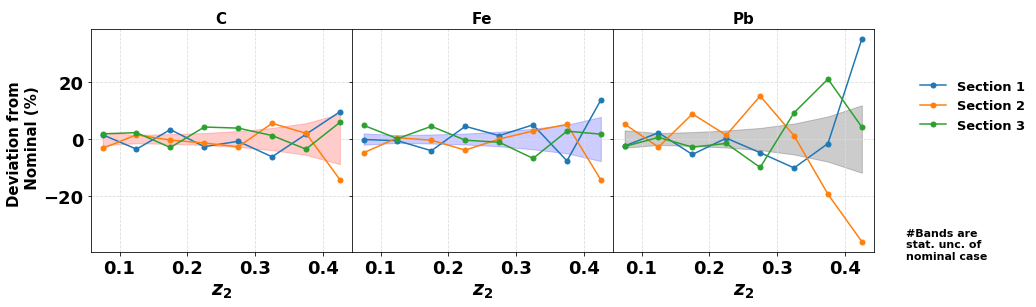

In [42]:
maxValue={}
minValue={}
maxValue['C']=[150000,300000,600000]
minValue['C']=[0 , 150000,300000]
maxValue['Fe']=[110000,220000,600000]
minValue['Fe']=[0 , 110000,220000]
maxValue['Pb']=[110000,220000,600000]
minValue['Pb']=[0 , 110000,220000]


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Section 1', 'Section 2','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom, minValue[target][2] , maxValue[target][2]  ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom, minValue[target][2] , maxValue[target][2]    ) )

    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
                
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('R2h_comp_1.png', bbox_inches='tight')

plt.show()

**trying only two section, i.e divide the sample in two chunks**

In [43]:
## this piece of code is just to select the ranges

maxValue={}
minValue={}
numberIntervals=3


maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

for l,target in enumerate(['C','Fe','Pb']):
    for i,tmp in enumerate(['tmp','tmp']):
        cut_ad=' and evnt>%d and evnt< %d'%(minValue[target][i] , maxValue[target][i])
        print('target: ',target, df[target].query(trigger_cut_nom+pair_cut_nom+cut_ad).shape[0] / df[target].query(trigger_cut_nom+pair_cut_nom).shape[0])
        
        
   
        

target:  C 0.4909179370742783
target:  C 0.5090820629257217
target:  Fe 0.5048294126811029
target:  Fe 0.495170587318897
target:  Pb 0.5
target:  Pb 0.5


Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>170000 and evnt < 600000
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957

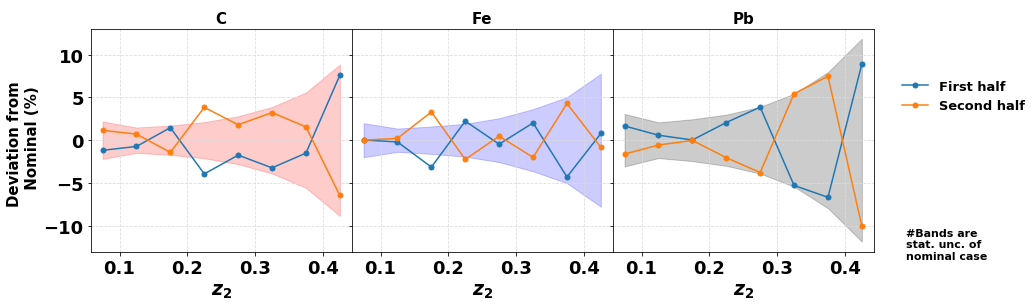

In [44]:
maxValue={}
minValue={}

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  =' and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
plt.savefig('R2h_compEvnt.pdf', bbox_inches='tight')
plt.savefig('R2h_compEvnt.png', bbox_inches='tight')

plt.show()

**As a function of $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>170000 and evnt < 600000
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957

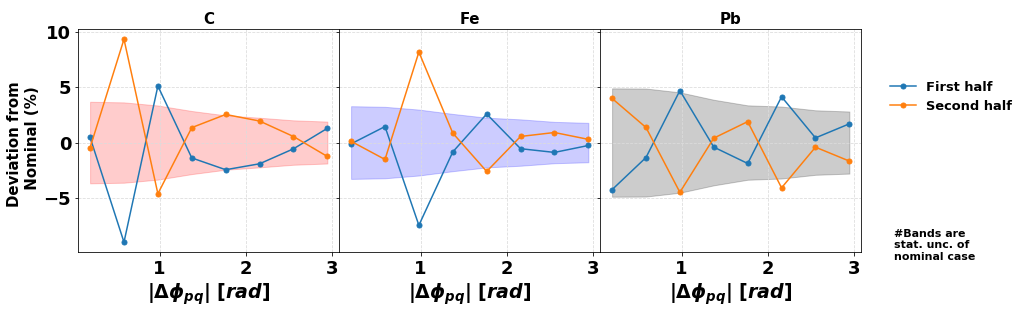

In [45]:
maxValue={}
minValue={}

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

varDep='dphi'
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable=varDep, 
                                    pair_cut ='%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable=varDep, 
                                       pair_cut = '%s and h2_z>0.1 and  evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable=varDep, 
                                       pair_cut = '%s and h2_z>0.1 and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
plt.savefig('R2h_compEvnt_diphi.pdf', bbox_inches='tight')
plt.savefig('R2h_compEvnt_diphi.png', bbox_inches='tight')

plt.show()

**As a function of pair Inv mass**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>170000 and evnt < 600000
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957

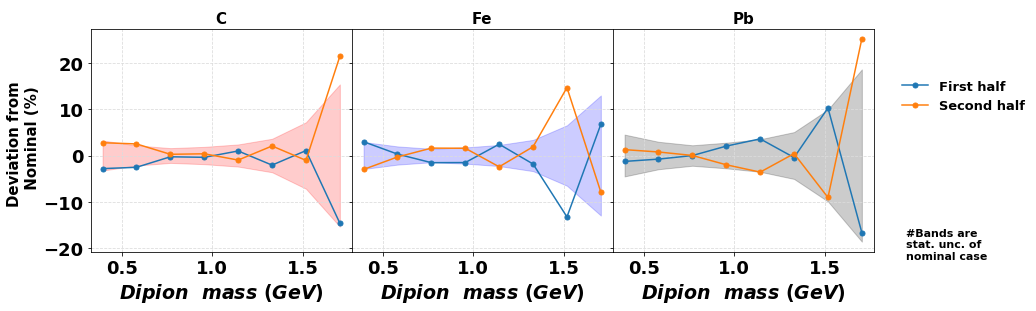

In [46]:
maxValue={}
minValue={}
maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

varDep='pair_mass'
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable=varDep, 
                                    pair_cut ='%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable=varDep, 
                                       pair_cut = '%s and h2_z>0.1 and  evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable=varDep, 
                                       pair_cut = '%s and h2_z>0.1 and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
plt.savefig('R2h_compEvnt_dipionMass.pdf', bbox_inches='tight')
plt.savefig('R2h_compEvnt_dipionMass.png', bbox_inches='tight')

plt.show()

**since we observe outlyers in the distributions, the idea here is to prove that , since we are using half the statistics in each case, those large uncertainties are related to the statistical uncertainty of the variation. I have to check that due to the fact that in the usual sys unc plots the stst uncertainty of the variation is not plotted**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 165000 
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and  evnt>170000 and evnt < 600000
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.1395

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and  evnt>0 and evnt < 220000 
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   and  evnt>165000 and evnt < 600000 
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

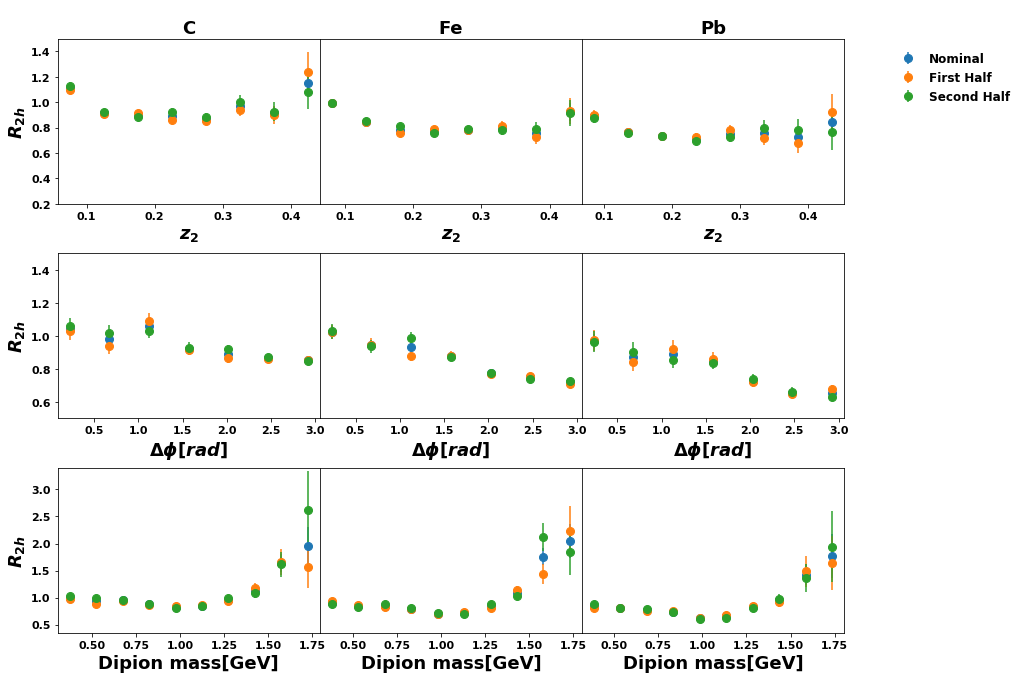

In [47]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,10),gridspec_kw={'hspace': 0.3, 'wspace':0.})
maxValue={}
minValue={}
numberIntervals=3

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                               pair_cut ='%s '%pair_cut_nom,
                               trig_cut ='%s '%trigger_cut_nom )
    axs[0][i].errorbar(x2+0.005*i,r2,yerr=err2,label='Nominal'if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                               pair_cut = '%s and  evnt>%d and evnt < %d '%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                               trig_cut ='%s and evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label='First Half'if i == 0 else "",fmt='o',ms=8) 

for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                               pair_cut = '%s and  evnt>%d and evnt < %d '%(pair_cut_nom,minValue[target][1] , maxValue[target][1]   ),
                               trig_cut ='%s and evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label='Second Half'if i == 0 else "",fmt='o',ms=8) 
    

### Dphi
dphiBins=8


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                               pair_cut ='%s  and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s '%trigger_cut_nom, nbins=dphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                               pair_cut = '%s and  evnt>%d and evnt < %d and h2_z>0.1  and h2_z<0.5'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ), nbins=dphiBins)
    axs[1][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 

for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                               pair_cut = '%s and  evnt>%d and evnt < %d and h2_z>0.1  and h2_z<0.5'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ), nbins=dphiBins)
    axs[1][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    
    
    
### Inv Mass
dpionMassBins=11


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s '%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = '%s and  evnt>%d and evnt < %d  and  h2_z>0.1 '%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    axs[2][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = '%s and  evnt>%d and evnt < %d  and  h2_z>0.1 '%(pair_cut_nom,minValue[target][1] , maxValue[target][1]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )
    axs[2][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    


            
for i in range(3):    
    axs[0][i].set_xlabel('$z_{2}$',fontsize=18)
    axs[1][i].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
    axs[2][i].set_xlabel('Dipion mass[GeV]',fontsize=18,fontweight='bold')

    
axs[0][0].set_title('C',fontsize=18,fontweight='bold')
axs[0][1].set_title('Fe',fontsize=18,fontweight='bold')
axs[0][2].set_title('Pb',fontsize=18,fontweight='bold')
#axs[0][0].set_ylabel('C \n $R_{2h}$',fontsize=18,fontweight='bold')
#axs[1][0].set_ylabel('Fe \n $R_{2h}$',fontsize=18,fontweight='bold')
#axs[2][0].set_ylabel('Pb \n $R_{2h}$',fontsize=18,fontweight='bold')

    
axs[0][0].set_ylabel('$R_{2h}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('$R_{2h}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('$R_{2h}$',fontsize=18,fontweight='bold')
for i in range(3): 
    axs[0][i].set_ylim([0.2,1.5])
    axs[1][i].set_ylim([0.5,1.5])
    axs[2][i].set_ylim([0.35,3.4])

#for i in range(3):    
#    axs[i][1].set_ylim([0.5,1.5])
#    axs[i][0].set_ylim([0.2,1.5])
#    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(1,3):
    axs[0][i].yaxis.set_visible(False)    
    axs[1][i].yaxis.set_visible(False)    
    axs[2][i].yaxis.set_visible(False)      

plt.subplots_adjust(right=0.83, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
#plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
plt.savefig('test_TimeDependenceR2hThreevariables.png', bbox_inches='tight')
plt.show()